# Pneumonia Detection in Chest X-Rays: Build and Train Model

---

# Import

In [1]:
%run pack_fun.py

Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(333)

---

# Load data & Preprocessing

In [3]:
## Load the NIH data
df_all_xray = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', df_all_xray.shape[0])
df_all_xray['img_path'] = df_all_xray['Image Index'].map(all_image_paths.get)
df_all_xray = df_all_xray.drop('Unnamed: 11', axis=1)
df_all_xray.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],img_path
13972,00003610_003.png,No Finding,3,3610,29,F,PA,2992,2991,0.143000,0.143000,/data/images_002/images/00003610_003.png
110179,00029989_000.png,Nodule,0,29989,31,M,PA,2021,2021,0.194314,0.194314,/data/images_012/images/00029989_000.png
60956,00015043_000.png,Nodule,0,15043,35,M,PA,2992,2991,0.143000,0.143000,/data/images_007/images/00015043_000.png


In [4]:
# Split multiple labels to flag 0/1 column
labels = get_unique_labels(df_all_xray['Finding Labels'])
df_all_xray = split_col_labels(df_all_xray, labels)
df_all_xray['class'] = df_all_xray['Pneumonia'].map(lambda x: 'P' if x == 1 else 'N')

# Gender
df_all_xray['Patient Gender'] = df_all_xray['Patient Gender'].map(lambda x: x.upper()=='M').astype('float32')

# Drop age outliers
df_all_xray['Patient Age'] = np.clip(df_all_xray['Patient Age'], 1, 100)

---

# Split train and validation set

**Training Set:**

In the training set, our goal is to create an evenly balanced dataset comprising 50% positive and 50% negative cases. This balance ensures that each class contributes equally to the loss function, typically represented by cross-entropy loss. However, due to the very small proportion of pneumonia records (only 1.28% of the dataset - 1431), achieving this balance requires discarding some negative cases.

**Validation Set:**

For the validation set, we aim to maintain the original positive/negative class imbalance to ensure that the validation metric accurately reflects real-world data, akin to test data. However, the scarcity of pneumonia records poses a challenge. Maintaining this ratio would result in an inadequate number of positive cases in the validation set, providing insufficient information for evaluation.

To address this issue, I've chosen to include 10% positive and 90% negative cases in the validation set. While this approach may not perfectly mirror real-world conditions, it strikes a balance between representativeness and informativeness, serving the objectives of the current cap-stone project effectively.


In [5]:
df_train, df_val = create_splits(df_all_xray, 333)

df_train = balance_train_target_proportions(df_train)

p_train_ratio = len(df_train[df_train['class'] == 'P'])/len(df_train)    
print('''Train % Pneumonia: \t{:.2f}%'''.format(p_train_ratio*100))

df_val = balance_val_target_proportions(df_val)

p_val_ratio = len(df_val[df_val['class'] == 'P'])/len(df_val)
print('''Val % Pneumonia: \t{:.2f}%'''.format(p_val_ratio*100))

print('''\nTrain set data: \t{}\nVal set data: \t\t{}'''.format(df_train.shape[0], df_val.shape[0]))

Train % Pneumonia: 	50.00%
Val % Pneumonia: 	20.00%

Train set data: 	2290
Val set data: 		1430


---

# Image Augmentation at train data

* **Pixel Normalization**: scale pixel values from the range of 0-255 to the range 0-1 preferred for neural network models
* **Pixel Standardization**: scale pixel values to have a zero mean and unit variance.



## Raw image sample

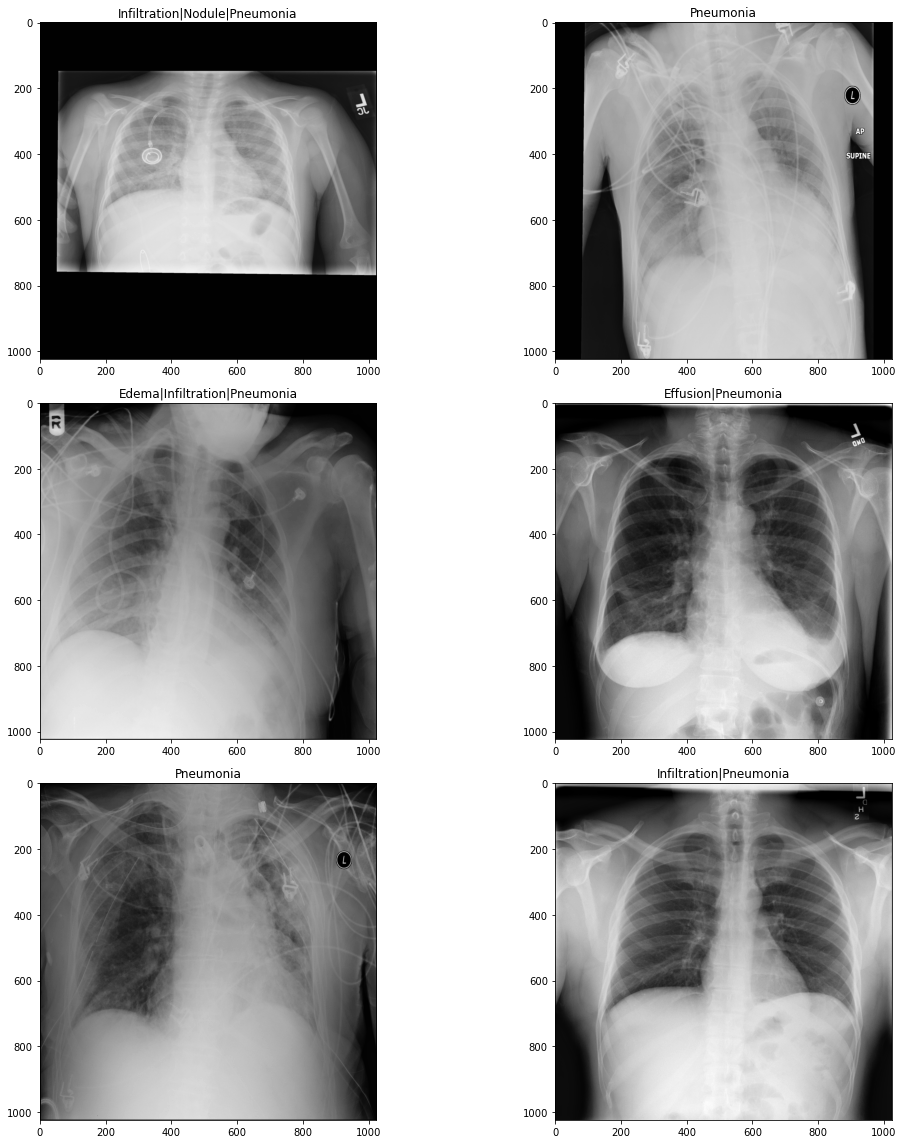

In [6]:
fig, m_axs = plt.subplots(3,2, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = df_train.img_path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(df_train.iloc[ind]['Finding Labels'])
    ind=ind+1

plt.tight_layout()

## Augmented image sample

Validation data shouldn't have any augmentation except for scaling

In [7]:
img_size = (224,224)

In [27]:
train_Aug = train_image(df_train, img_size)
val_Aug = val_image(df_val, img_size)

Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


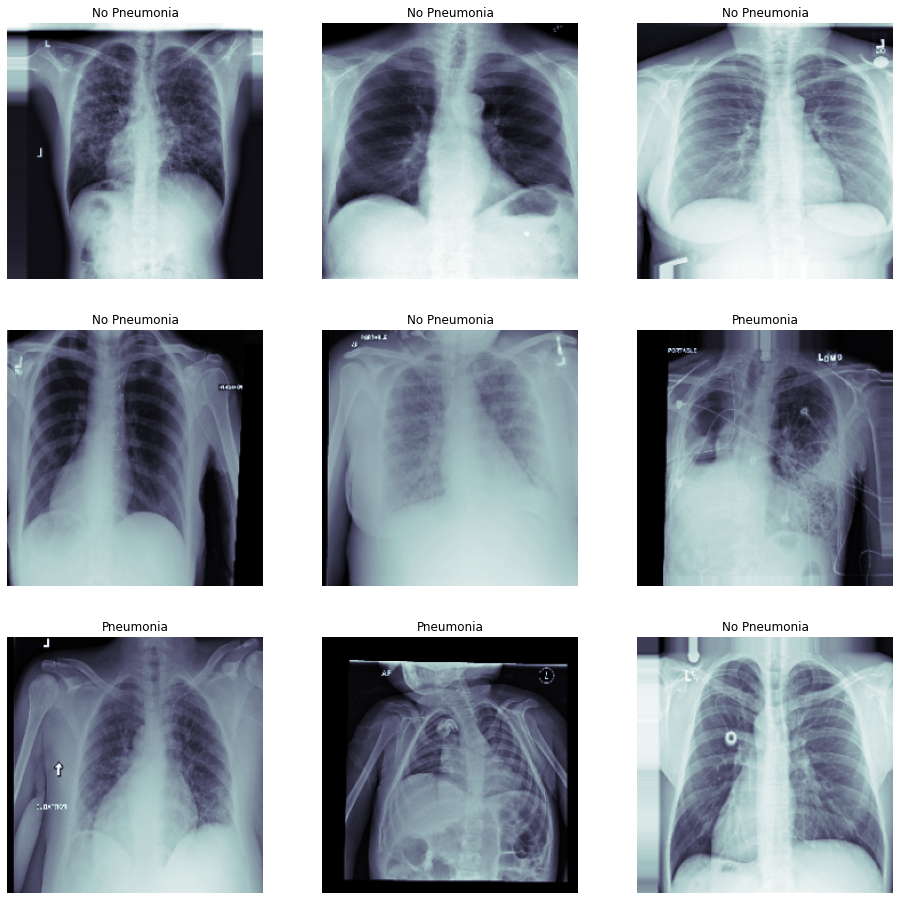

In [9]:
plot_img_Aug(train_Aug, 3, 3)

---

# VGG16 CNN with Attention Model Configuration

In [28]:
X_train, y_train = next(train_Aug)

In [29]:
X_train.shape[1:]

(224, 224, 3)

In [30]:
model_name = 'Attention CNN VGG'

In [31]:
# Load the pre-trained VGG16 model, remove the top fully connected layer, and keep only the convolutional part.
pretrain_model = VGG16(input_shape = X_train.shape[1:],
                       include_top = False,
                       weights = 'imagenet')

pretrain_features = Input(pretrain_model.get_output_shape_at(0)[1:], name = 'feature_input')
pretrain_depth = pretrain_model.get_output_shape_at(0)[-1]
batchnorm_features = BatchNormalization(name='features_batch_norm')(pretrain_features)

# Add attention layer
attn_layer = Conv2D(128, kernel_size = (1,1), padding = 'same', activation = 'elu')(batchnorm_features)
attn_layer = Conv2D(32, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'elu')(attn_layer)
attn_layer = AvgPool2D((2,2), strides = (1,1), padding = 'same')(attn_layer)
attn_layer = Conv2D(1, kernel_size = (1,1), padding = 'valid', activation = 'sigmoid', name='AttentionMap2D')(attn_layer)

up_c2_w = np.ones((1, 1, 1, pretrain_depth))
up_c2 = Conv2D(pretrain_depth, 
               kernel_size = (1,1), 
               padding = 'same', 
               activation = 'linear', 
               use_bias = False, 
               weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, batchnorm_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

# Prediction
gap_dr = Dropout(0.2)(gap)
dr_steps = Dropout(0.2)(Dense(128, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'sigmoid')(dr_steps)


In [32]:
attn_model = Model(inputs = [pretrain_features], outputs = [out_layer], name = 'attention_layer')

attn_model.compile(optimizer = Adam(lr=0.0001),
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy'])

attn_model.summary()

Model: "attention_layer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
feature_input (InputLayer)      (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
features_batch_norm (BatchNorma (None, 7, 7, 512)    2048        feature_input[0][0]              
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 7, 7, 128)    65664       features_batch_norm[0][0]        
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 7, 7, 32)     4128        conv2d_9[0][0]                   
____________________________________________________________________________________

In [33]:
model = Sequential(name = 'Attention_CNN_model')
pretrain_model.trainable = False
model.add(pretrain_model)
model.add(attn_model)
model.compile(optimizer = Adam(lr=0.0001),
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy'])
model.summary()

Model: "Attention_CNN_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
attention_layer (Model)      (None, 1)                 138690    
Total params: 14,853,378
Trainable params: 137,154
Non-trainable params: 14,716,224
_________________________________________________________________


In [34]:
weight_path = "weights/{}_weights.best.hdf5".format(model_name)

epochs = 100

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # will be stopped if loss does not reduce after 10 steps

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss',
                                   patience=5, #if val loss not improving for 5 steps
                                   factor=0.8, #reduce by factor 0.8
                                   verbose=1,
                                   mode='auto',
                                   min_delta=0.0001,
                                   cooldown=5,
                                   min_lr=0.0001)
checkpoint = ModelCheckpoint(weight_path,
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_weights_only = True)

callbacks_list = [checkpoint,
                  early,
                  reduceLROnPlat]

In [35]:
X_val, y_val = val_Aug.next()

In [36]:
X_val.shape

(1024, 224, 224, 3)

In [37]:
y_val.shape

(1024,)

In [38]:
%%time
train_Aug.batch_size = 32
history = model.fit_generator(train_Aug,
                              validation_data = (X_val, y_val), 
                              steps_per_epoch=train_Aug.n//train_Aug.batch_size,
                              epochs = epochs,
                              callbacks = callbacks_list)

Epoch 1/100
71/71 [==============================] - 61s 859ms/step - loss: 0.6935 - binary_accuracy: 0.5452 - val_loss: 0.8702 - val_binary_accuracy: 0.2793

Epoch 00001: val_loss improved from inf to 0.87024, saving model to weights/Attention CNN VGG_weights.best.hdf5
Epoch 2/100
71/71 [==============================] - 60s 840ms/step - loss: 0.6663 - binary_accuracy: 0.5921 - val_loss: 0.8829 - val_binary_accuracy: 0.2793

Epoch 00002: val_loss did not improve from 0.87024
Epoch 3/100
71/71 [==============================] - 59s 829ms/step - loss: 0.6539 - binary_accuracy: 0.6337 - val_loss: 0.9232 - val_binary_accuracy: 0.2793

Epoch 00003: val_loss did not improve from 0.87024
Epoch 4/100
71/71 [==============================] - 58s 822ms/step - loss: 0.6447 - binary_accuracy: 0.6355 - val_loss: 0.9099 - val_binary_accuracy: 0.2832

Epoch 00004: val_loss did not improve from 0.87024
Epoch 5/100
71/71 [==============================] - 59s 837ms/step - loss: 0.6453 - binary_accurac

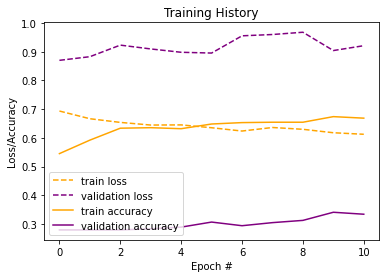

In [39]:
plot_history(history, model_name)

The training loss steadily decreases, the training accuracy steadily increases, but the validation loss fluctuates significantly and remains at a high level, indicating that the validation set is not representative enough (even though it has increased the positive rate from 1.28% to 20%).

In [40]:
model.save('{}.h5'.format(model_name))

In [41]:
model.load_weights(weight_path)

In [42]:
y_pred = model.predict(
    X_val,
    batch_size = 64,
    verbose = True
)

1024/1024 [==============================] - 10s 10ms/step


In [33]:
y_pred.shape

(1024, 1)

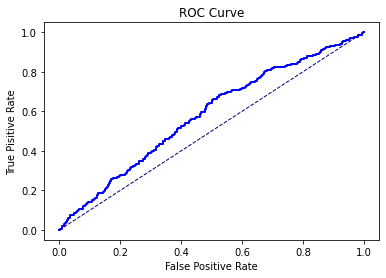

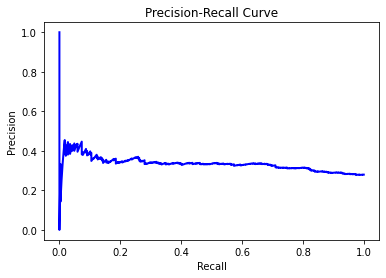

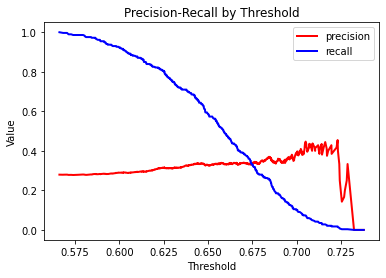

In [43]:
plot_auc(y_val, y_pred)
plot_pr(y_val, y_pred)
plot_pr_th(y_val, y_pred)

## Evaluate

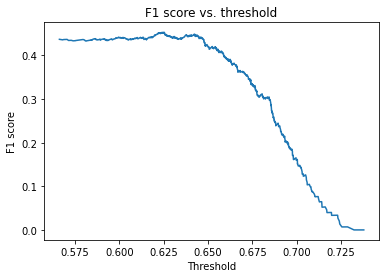

Precision: 0.31550068587105623
Recall: 0.8041958041958042
Threshold: 0.62521714
F1 Score: 0.45320197044334976


In [44]:
best_threshold = find_optimal_th(y_val, y_pred)

In [45]:
tn, fp, fn, tp = confusion_matrix(y_val, (y_pred > best_threshold).astype(int)).ravel()

In [46]:
npv = tn / (tn + fn)
ppv = tp / (tp + fp)
spec = tn / (tn + fp)

In [47]:
print('Recall: {}'.format(npv))
print('Precision: {}'.format(ppv))
print('Specificity: {}'.format(spec))

Recall: 0.8074324324324325
Precision: 0.31456043956043955
Specificity: 0.3238482384823848


* The model exhibits a high Recall (0.81), indicating its ability to accurately predict positive cases (pneumonia) among all actual positive cases. This is crucial for minimizing false negatives, ensuring fewer cases of pneumonia are missed. However, the Precision (0.31) is relatively low, suggesting a considerable proportion of false positives when the model predicts positive cases. This could lead to overdiagnosis. Additionally, the Specificity (0.32) is also not very high, indicating a lower accuracy in predicting negative cases (no pneumonia) among all actual negative cases. Consequently, when applying this model, a trade-off between Recall and Precision needs to be considered to determine appropriate thresholds, and further refinement is necessary to enhance the overall performance of the model.



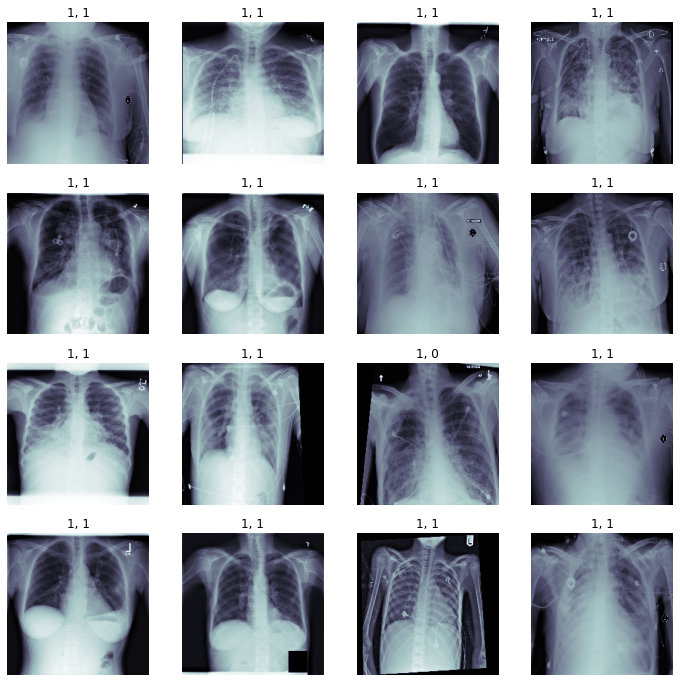

In [39]:
fig, m_axs = plt.subplots(4, 4, figsize = (12, 12))
i = 0

for (c_x, c_y, c_ax) in zip(X_val[0:16], y_val[0:16], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if y_pred[i] > best_threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if y_pred[i] > best_threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [40]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("{}-model.json".format(model_name), "w") as json_file:
    json_file.write(model_json)